In [2]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
import seaborn as sns
import skimage.io as skio
from tifffile import TiffFile

from atlas import loadmat, NPAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, combine_datasets, get_pairings
from stats import get_summary_stats, analyze_pairs
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats 

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

## Figure 1: NWB extension for optophysiology in C. elegans

This will probably be an illustrator created visual which shows all of the different objects that go into the NWB file and how they interplay with each other. Similar to how it is shown in the NWB tutorails

## Figure 2: Software pipelines for working with NWB

## Table 1: Summary of collected datasetes

Columns will be: source paper, lab, number of worms, NP/GCaMP/both, average num segmented neurons, average num ID labels, notes

## Figure 3: Summary statistics of datasets

Unprocessed data from each dataset run through NP software, box-whisker plot, plus additional box for performance of consolidated dataset

   seg   ID  labels
0  183  183  Yemini
1  166  164  Yemini
2  178  175  Yemini
3  184  180  Yemini
4  180  175  Yemini


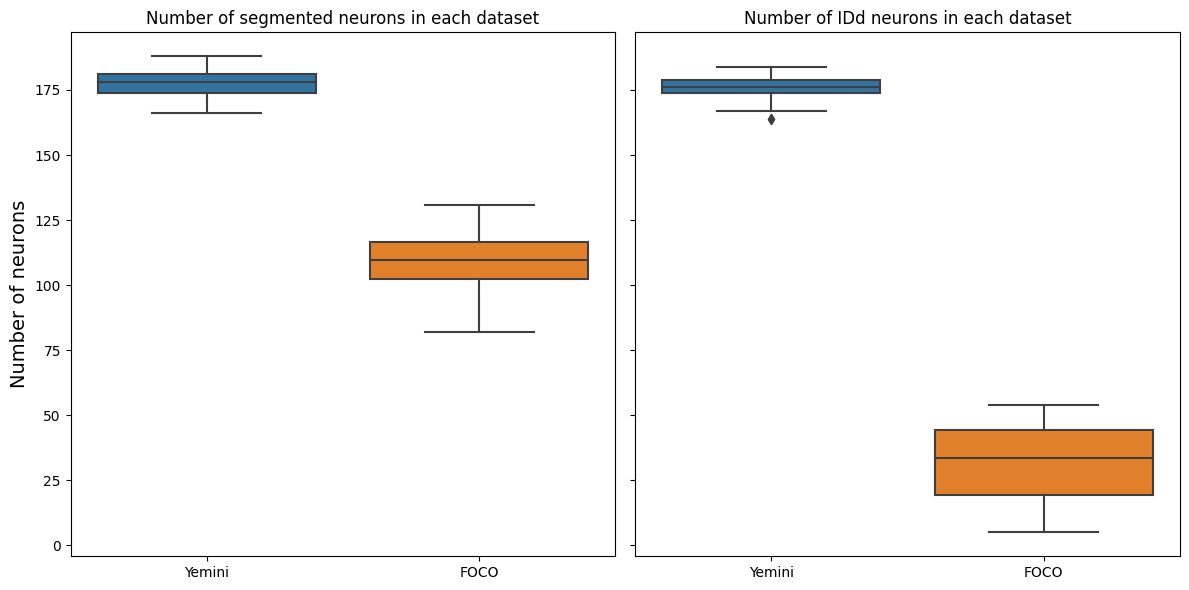

In [4]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

Yem_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/Yemini_NWB')
FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray')

num_seg_yem, num_ID_yem = get_summary_stats(Yem_dataset)
num_seg_FOCO, num_ID_FOCO = get_summary_stats(FOCO_dataset)

plot_summary_stats([num_seg_yem, num_seg_FOCO], [num_ID_yem, num_ID_FOCO], ['Yemini', 'FOCO'])

In [5]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([Yem_dataset, FOCO_dataset])
print(tot_dataset.keys())

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04'])


In [6]:
pair_yem = get_pairings(Yem_dataset)

In [7]:
pair_tot = get_pairings(tot_dataset)

In [8]:
atlas = NPAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/atlas_xx_rgb.mat', ganglia ='/Users/danielysprague/foco_lab/data/atlases/neuron_ganglia.csv' )
atlas.create_dictionary()
df = atlas.get_df()

In [10]:
def plot_std_heatmap(num_heatmap, std_heatmap, df_ganglia):

    ganglia_indices = {}

    for ganglion in df_ganglia['ganglion'].unique():
        # Find the indices where the category starts and ends
        start_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][0]
        end_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][-1]
        
        # Store the start and end indices in the dictionary
        ganglia_indices[ganglion] = (start_index, end_index)

    # Create the figure and ax objects
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('black')

    mask = np.where(num_heatmap < 0.4, True, False)

    # Create the heatmap using the ax object
    sns.heatmap(std_heatmap, cmap='Reds')

    highlight_boxes = [((ganglia_indices[gang][0], ganglia_indices[gang][0]), (ganglia_indices[gang][1], ganglia_indices[gang][1]), gang) for gang in df_ganglia['ganglion'].unique()]

    # Overlay boxes
    for (x1, y1), (x2, y2), label in highlight_boxes:
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='black', lw=3))
        if x1<len(df_ganglia)/2:
            plt.text(x2+2, (y1 + y2) / 2, label, color='black', ha='left', va='center')
        else:
            plt.text(x1-2, (y1 + y2) / 2, label, color='black', ha='right', va='center')

    ax.set_title('Standard deviation of pairwise distances')
    plt.tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False)  # Hide tick labels
    plt.show()

def plot_num_heatmap(num_heatmap, df_ganglia):
    ganglia_indices = {}

    for ganglion in df_ganglia['ganglion'].unique():
        # Find the indices where the category starts and ends
        start_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][0]
        end_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][-1]
        
        # Store the start and end indices in the dictionary
        ganglia_indices[ganglion] = (start_index, end_index)

    # Create the figure and ax objects
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('black')

    mask = np.where(num_heatmap < 0.4, True, False)

    # Create the heatmap using the ax object
    sns.heatmap(num_heatmap, cmap='Reds')

    highlight_boxes = [((ganglia_indices[gang][0], ganglia_indices[gang][0]), (ganglia_indices[gang][1], ganglia_indices[gang][1]), gang) for gang in df_ganglia['ganglion'].unique()]

    # Overlay boxes
    for (x1, y1), (x2, y2), label in highlight_boxes:
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='black', lw=3))
        if x1<len(df_ganglia)/2:
            plt.text(x2+2, (y1 + y2) / 2, label, color='black', ha='left', va='center')
        else:
            plt.text(x1-2, (y1 + y2) / 2, label, color='black', ha='right', va='center')

    ax.set_title('Fraction of datasets each pairing appears in')
    plt.tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False)  # Hide tick labels
    plt.show()

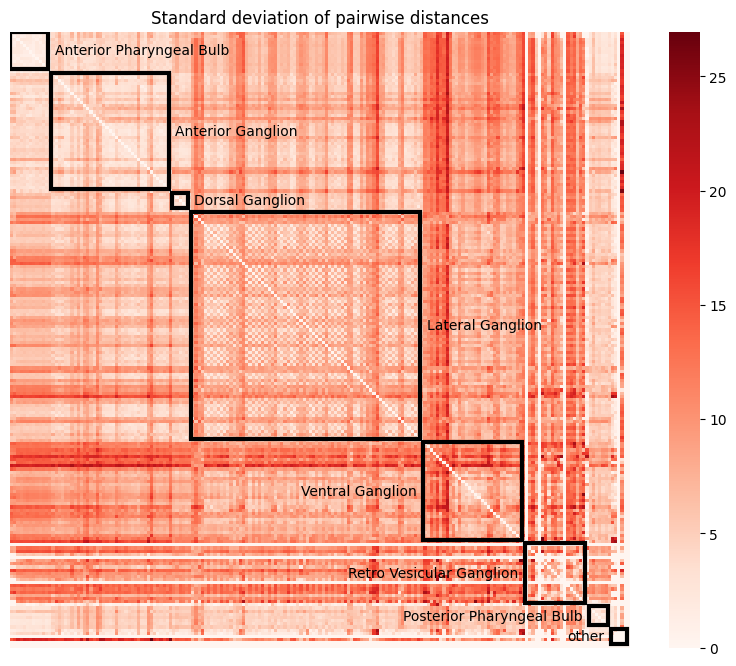

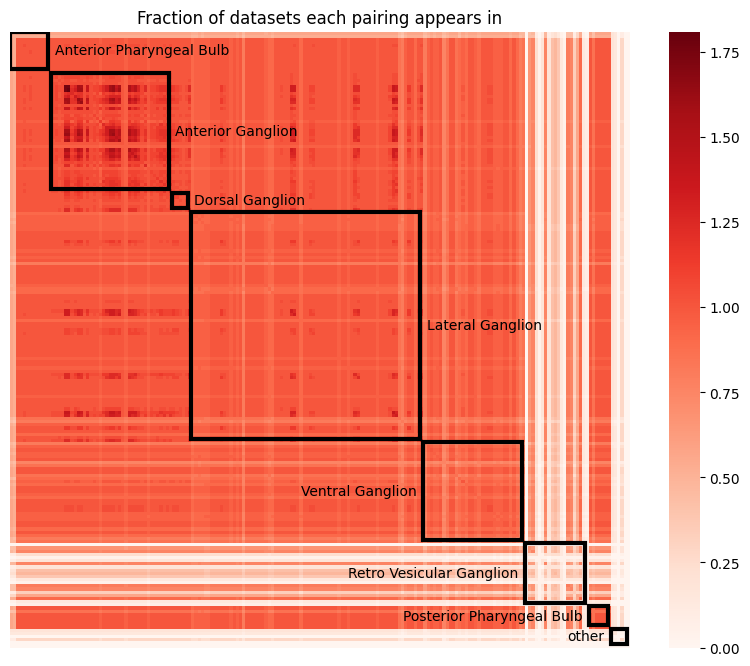

In [11]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_yem, df, 21)
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

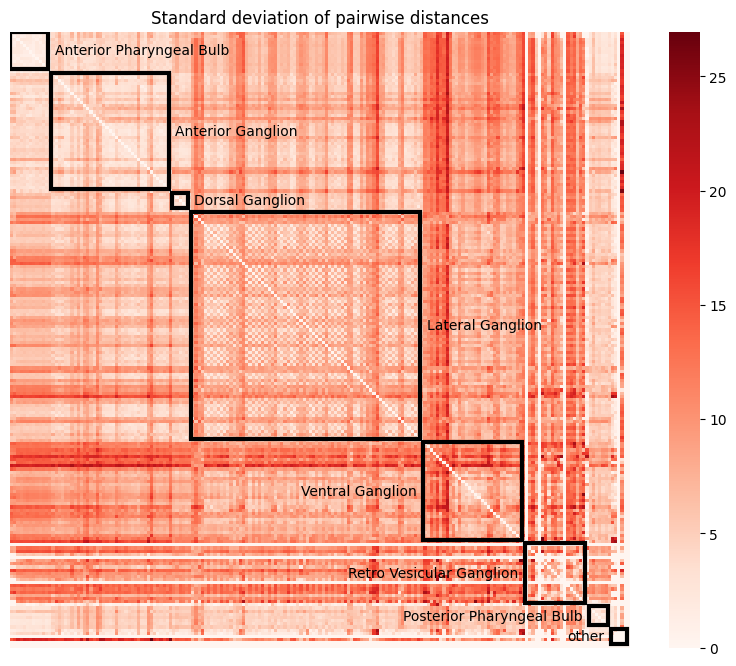

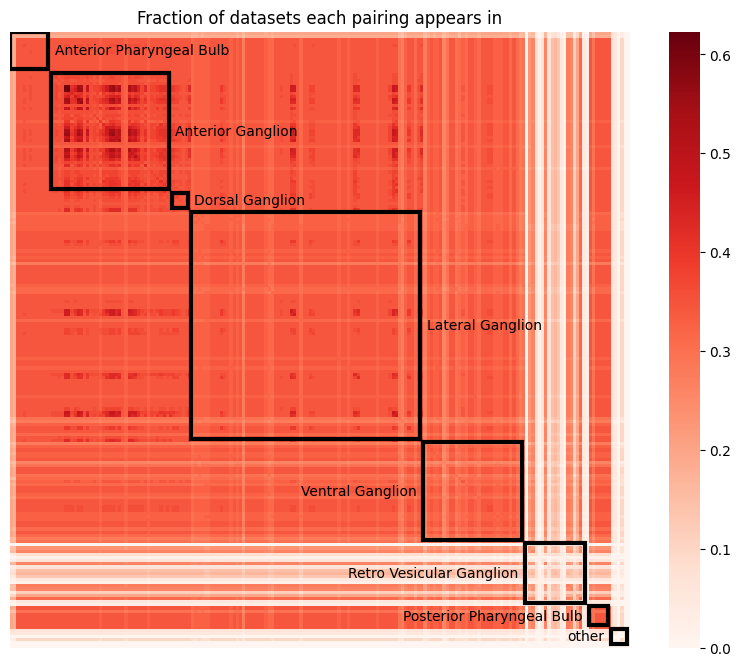

In [14]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_tot, df, len(Yem_dataset.keys())+len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

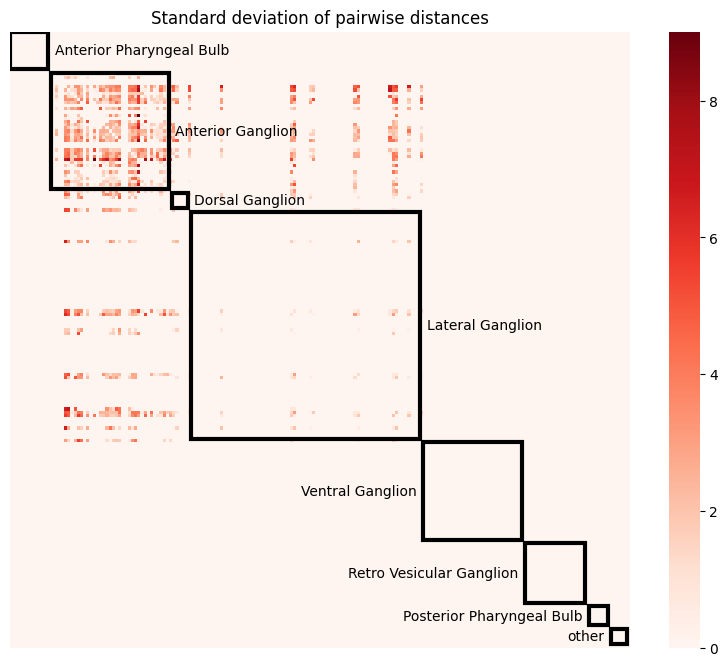

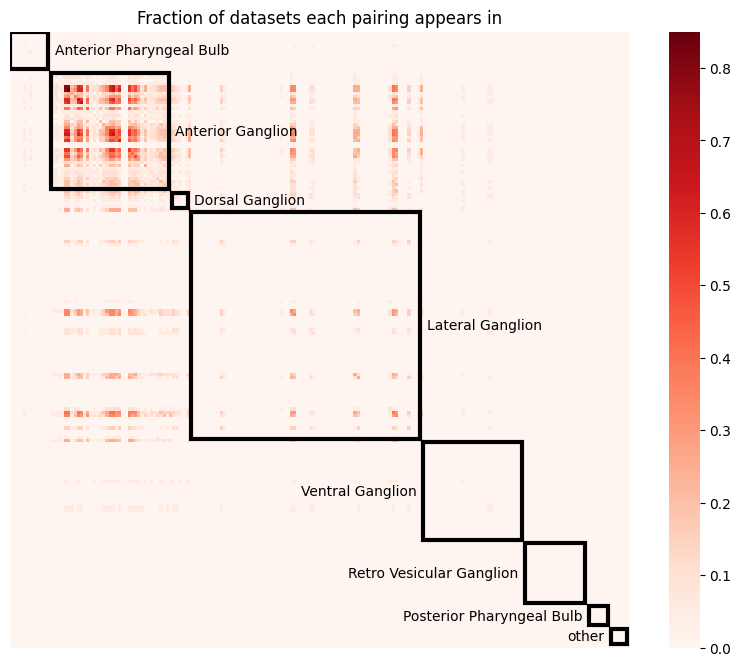

In [15]:
pair_FOCO = get_pairings(FOCO_dataset)
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_FOCO, df, len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

### Color statistics of datasets

In [29]:
def get_color_stats(folder):

    rgbhist = np.zeros((32,3))

    neur_colors = {}

    for file in os.listdir(folder):
        if not file[-4:] == '.nwb':
            continue

        print(file)

        blobs, rgb_data = get_nwb_neurons(folder+'/'+file)

        color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))

        blobs[['Rnorm', 'Gnorm','Bnorm']] = np.nan

        for i, row in blobs.iterrows():
            colors = color_norm[max(row['x']-2,0):min(row['x']+2,rgb_data.shape[0]-1),max(row['y']-2,0):min(row['y']+2,rgb_data.shape[1]-1),max(row['z']-1,0):min(row['z']+1,rgb_data.shape[2]-1),:]

            flat_colors = colors.reshape(-1, colors.shape[-1])
            
            Rnorm = np.median(flat_colors[0])
            Gnorm = np.median(flat_colors[1])
            Bnorm = np.median(flat_colors[2])

            blobs.loc[i, 'Rnorm'] = Rnorm
            blobs.loc[i, 'Gnorm'] = Gnorm
            blobs.loc[i, 'Bnorm'] = Bnorm

        IDd = blobs[blobs['ID']!='']

        for i, row in IDd.iterrows():
            ID = row['ID']
            colors = np.asarray(row[['Rnorm', 'Gnorm', 'Bnorm']])
            if not ID in neur_colors:
                neur_colors[ID] = [colors]
            else:
                neur_colors[ID].append(colors)
            
        image = np.asarray(color_norm)
        im_flat = image.reshape(-1, image.shape[-1])

        rhist, bins = np.histogram(im_flat[:,0], bins=32, range=(0,1))
        ghist, bins = np.histogram(im_flat[:,1], bins=32, range=(0,1))
        bhist, bins = np.histogram(im_flat[:,2], bins=32, range=(0,1))

        rgbhist[:,0] += rhist
        rgbhist[:,1] += ghist
        rgbhist[:,2] += bhist
    
    rgbhist[:,0] = rgbhist[:,0]/np.sum(rgbhist[:,0])
    rgbhist[:,1] = rgbhist[:,1]/np.sum(rgbhist[:,1])
    rgbhist[:,2] = rgbhist[:,2]/np.sum(rgbhist[:,2])

    return rgbhist, neur_colors

In [30]:
foco_rgb, foco_colors = get_color_stats('/Users/danielysprague/foco_lab/data/NWB_Ray')
yem_rgb, yem_colors = get_color_stats('/Users/danielysprague/foco_lab/data/Yemini_NWB')


20230412-20-15-17.nwb
20230506-14-24-57.nwb
20230510-13-25-46.nwb
20230322-22-43-03.nwb
20221106-21-47-31.nwb
20230506-12-56-00.nwb
20221106-21-00-09.nwb
20230322-20-16-50.nwb
20221028-18-48-00.nwb
20230506-13-32-08.nwb
20230510-16-36-46.nwb
20230506-15-33-51.nwb
20230510-15-49-47.nwb
20221215-20-02-49.nwb
20230322-21-41-10.nwb
20221106-21-23-19.nwb
20230506-15-01-45.nwb
20230510-12-53-34.nwb
20221215-22-02-55.nwb
20230322-18-57-04.nwb
20190928_08.nwb
20190929_02.nwb
20190929_03.nwb
20190925_01.nwb
20191030_07.nwb
20190925_04.nwb
20191030_03.nwb
20190929_05.nwb
20190929_07.nwb
20190929_06.nwb
20191104_10.nwb
20191104_08.nwb
20190924_01.nwb
20190928_01.nwb
20190928_03.nwb
20190924_03.nwb
20190924_02.nwb
20190928_13.nwb
20190928_07.nwb
20190928_11.nwb
20190928_05.nwb


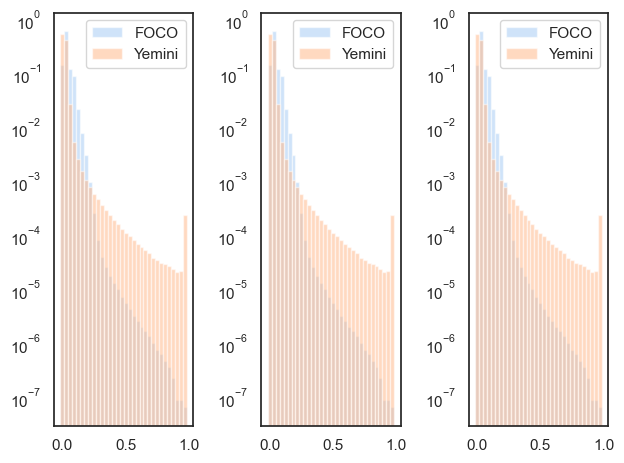

In [31]:
sns.set(style="white")
fig, axs = plt.subplots(1,3)

# Plot the bars using Matplotlib

bin_edges = np.arange(32)/32

for i, ax in enumerate(axs):
    #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
    ax.bar(bin_edges[:], foco_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[0], log=True, label='FOCO')
    ax.bar(bin_edges[:], yem_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[1], log=True, label='Yemini')
    ax.legend()
    #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(foco_rgb[:,i]), bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='FOCO')
    #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(yem_rgb[:,i]), bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='Yemini')

plt.tight_layout()
plt.show()


In [27]:
blobs, rgb_data = get_nwb_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray/20230322-21-41-10.nwb')
color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))
image = np.asarray(color_norm)
im_flat = image.reshape(-1, image.shape[-1])

blobs2, rgb_data2 = get_nwb_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray/20221215-22-02-55.nwb')
color_norm_2 = color_norm = (rgb_data2 - np.min(rgb_data2, axis=(0,1,2))) / (np.max(rgb_data2, axis=(0,1,2))- np.min(rgb_data2, axis=(0,1,2)))
im_flat2 = color_norm_2.reshape(-1, image.shape[-1])

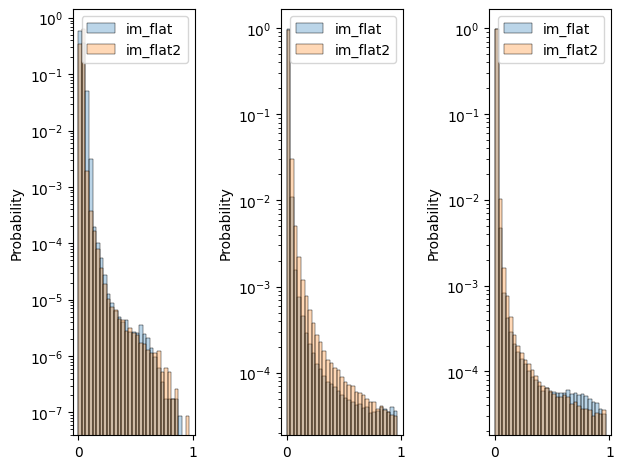

In [31]:
fig, axs = plt.subplots(1,3)
for i, ax in enumerate(axs):
    #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
    sns.histplot(ax=ax, data=im_flat[:,i], bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='im_flat')
    sns.histplot(ax=ax, data=im_flat2[:,i], bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='im_flat2')

    ax.legend()

plt.tight_layout()
plt.show()


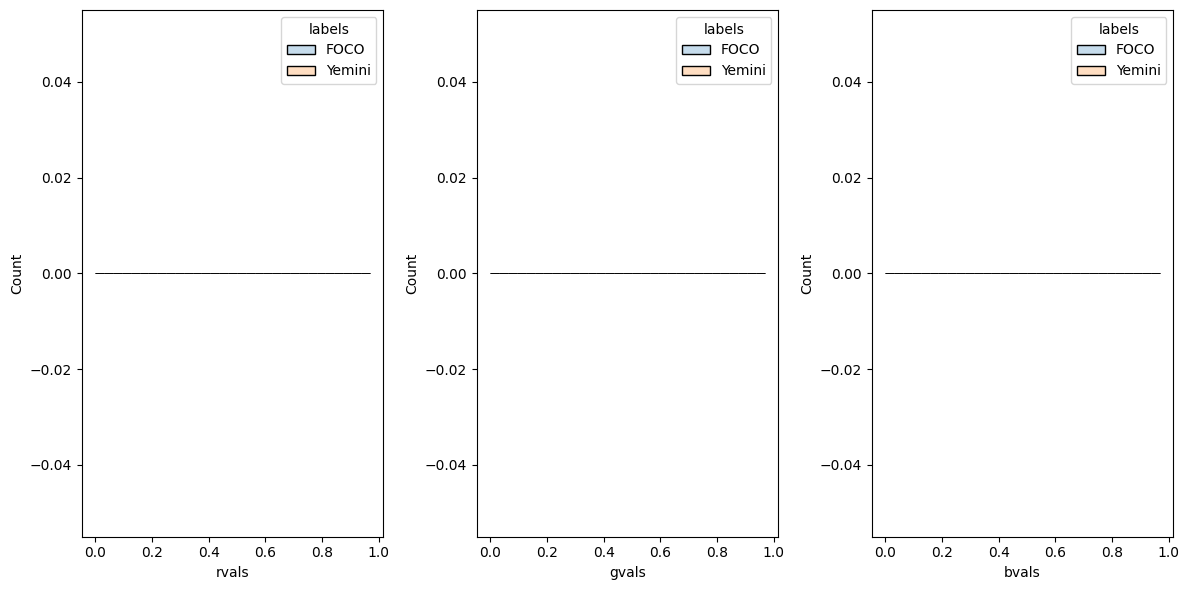

In [18]:
fig, axs = plt.subplots(1,3, figsize=(12,6))

labels = ['FOCO', 'Yemini']

rvals = np.hstack((foco_r, yem_r))
gvals = np.hstack((foco_g, yem_g))
bvals = np.hstack((foco_b, yem_b))
labels = np.hstack(tuple([labels[i]]*32 for i in range(len(labels))))

df = pd.DataFrame({'rvals':rvals,'gvals':gvals,'bvals':bvals,'labels':labels})

sns.histplot(ax=axs[0], data=df, x= 'rvals', hue='labels', bins=np.arange(32)/32, alpha=0.25)
sns.histplot(ax=axs[1], data=df, x= 'gvals', hue='labels', bins=np.arange(32)/32, alpha=0.25)
sns.histplot(ax=axs[2], data=df, x= 'bvals', hue='labels', bins=np.arange(32)/32, alpha=0.25)

plt.tight_layout()
plt.show()

In [347]:
df.head()

,rvals,gvals,bvals,labels
0,3479964.0,11454330.0,16817770.0,FOCO
1,14328225.0,6221886.0,5508295.0,FOCO
2,2863315.0,5514725.0,109629.0,FOCO
3,2136448.0,367612.0,101203.0,FOCO
4,514061.0,23867.0,378697.0,FOCO


In [19]:
print(foco_colors)

{'URADL': [Rnorm     0.02333
Gnorm    0.030697
Bnorm    0.031933
Name: 18, dtype: object, Rnorm    0.024336
Gnorm    0.023783
Bnorm    0.022124
Name: 5, dtype: object, Rnorm    0.054818
Gnorm    0.056767
Bnorm    0.050393
Name: 21, dtype: object], 'URYVL': [Rnorm    0.100958
Gnorm    0.074183
Bnorm    0.099975
Name: 21, dtype: object, Rnorm    0.074668
Gnorm    0.059181
Bnorm    0.065819
Name: 13, dtype: object, Rnorm    0.083505
Gnorm    0.076512
Bnorm    0.098725
Name: 29, dtype: object, Rnorm    0.114322
Gnorm    0.076633
Bnorm    0.128141
Name: 15, dtype: object], 'OLQVL': [Rnorm    0.070727
Gnorm    0.067534
Bnorm    0.084971
Name: 26, dtype: object, Rnorm     0.04049
Gnorm    0.042373
Bnorm    0.038606
Name: 19, dtype: object, Rnorm    0.072273
Gnorm    0.056505
Bnorm    0.067485
Name: 25, dtype: object, Rnorm    0.021142
Gnorm    0.019495
Bnorm    0.023339
Name: 25, dtype: object, Rnorm    0.068287
Gnorm    0.071833
Bnorm    0.054977
Name: 30, dtype: object, Rnorm    0.176682
Gn

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,6))

labels = ['FOCO', 'Yemini']

rvals = np.hstack((foco_r, yem_r))
gvals = np.hstack((foco_g, yem_g))
bvals = np.hstack((foco_b, yem_b))
labels = np.hstack(tuple([labels[i]]*32 for i in range(len(labels))))

df = pd.DataFrame({'rvals':rvals,'gvals':gvals,'bvals':bvals,'labels':labels})

sns.histplot(ax=axs[0], data=df, x= 'rvals', hue='labels', bins=np.arange(32)*128, alpha=0.25)
sns.histplot(ax=axs[1], data=df, x= 'gvals', hue='labels', bins=np.arange(32)*128, alpha=0.25)
sns.histplot(ax=axs[2], data=df, x= 'bvals', hue='labels', bins=np.arange(32)*128, alpha=0.25)

plt.tight_layout()
plt.show()

## Figure 4: Benchmarking performance of consolidated datasets 

All experiments run using consolidated dataset, different image processing approaches, box-whisker plot similar to above

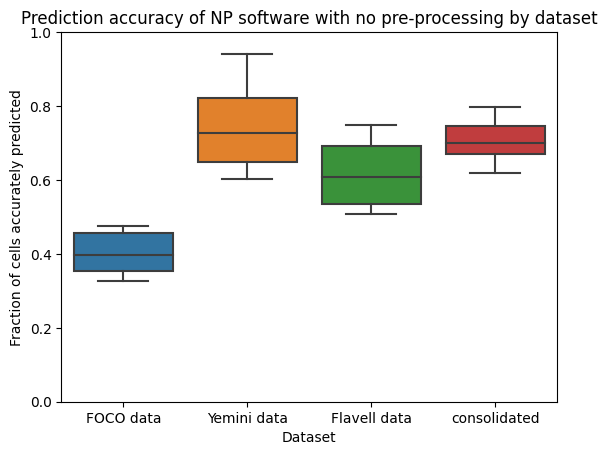

In [10]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['FOCO data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Yemini data']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Flavell data']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['consolidated']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software with no pre-processing by dataset')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Dataset')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

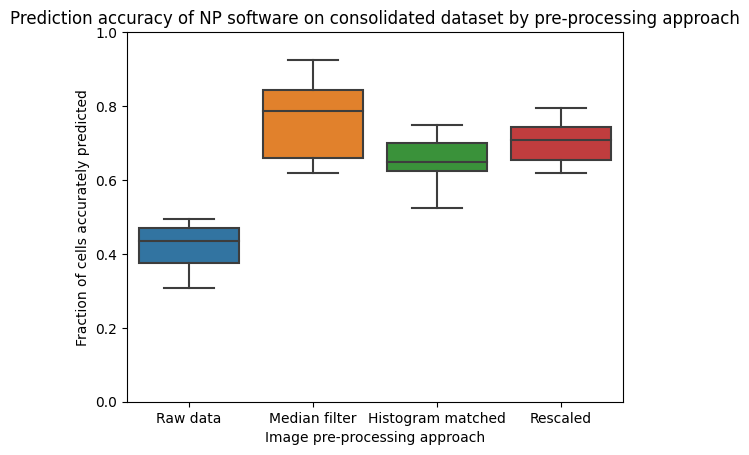

In [12]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['Raw data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Median filter']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Histogram matched']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['Rescaled']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software on consolidated dataset by pre-processing approach')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Image pre-processing approach')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

## Figure 5: Atlas visualizations - projected color space visualization, unrollled butterfly visualization